# Datu Vizualizācija un Ekstrapolēšana

## 3. Daļa - Cietais rieksts 🌰 (Papildus izaicinājums)

⏱️ **Paredzētais laiks: ~15+ minūtes (neobligāta daļa)**

Šajā nodarbībā mēs iemācīsimies:
- Slīdošo vidējo (Moving Average)
- Polinomu regresiju
- Datu kvalitātes novērtēšanu

### 📚 Noderīgas saites
- [Moving Average skaidrojums](https://www.investopedia.com/terms/m/movingaverage.asp) - finanšu kontekstā
- [Polinomu regresija](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression) - scikit-learn
- [R² un modeļu novērtēšana](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score) - kvalitātes metrikas

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [14, 6]

---

## 📸 Grafiku Saglabāšana / Saving Graphs

**Lai saglabātu jebkuru grafiku**, pievieno šo kodu **PIRMS** `plt.show()`:`

`python
# Saglabā grafiku / Save the graph
from datetime import datetime
import os

os.makedirs('../my_graphs', exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
plt.savefig(f'../my_graphs/{timestamp}_graph_name.png', dpi=300, bbox_inches='tight')
print(f'✅ Grafiks saglabāts!')
`python

**Piezīmes:**
- Nomainiet `graph_name` ar aprakstošu nosaukumu (piemēram, `coffee_sales`, `trend_line`)
- Grafiki tiek saglabāti `my_graphs/` mapē ar laika zīmogu
- Pilnu dokumentāciju skatīt: `GRAPH_SAVING_SNIPPET.md`

---


In [2]:
# Ielādējam un sagatavojam datus
df = pd.read_csv('../data/coffee_sales/index_1.csv')
df['date'] = pd.to_datetime(df['date'])
df['datetime'] = pd.to_datetime(df['datetime'])

# Dienas ieņēmumi
daily = df.groupby('date').agg({
    'money': 'sum',
    'coffee_name': 'count'
}).reset_index()
daily.columns = ['date', 'revenue', 'sales_count']
daily['day_number'] = range(len(daily))

daily.head()

,date,revenue,sales_count,day_number
0,2024-03-01,396.3,11,0
1,2024-03-02,228.1,7,1
2,2024-03-03,349.1,10,2
3,2024-03-04,135.2,4,3
4,2024-03-05,338.5,9,4


---

## 3.1 Slīdošais vidējais (Moving Average)

Slīdošais vidējais palīdz izlīdzināt datus un redzēt tendences bez ikdienas svārstībām.

Piemēram, 7 dienu slīdošais vidējais katrai dienai aprēķina vidējo no pēdējām 7 dienām.

📖 [Pandas rolling() dokumentācija](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)

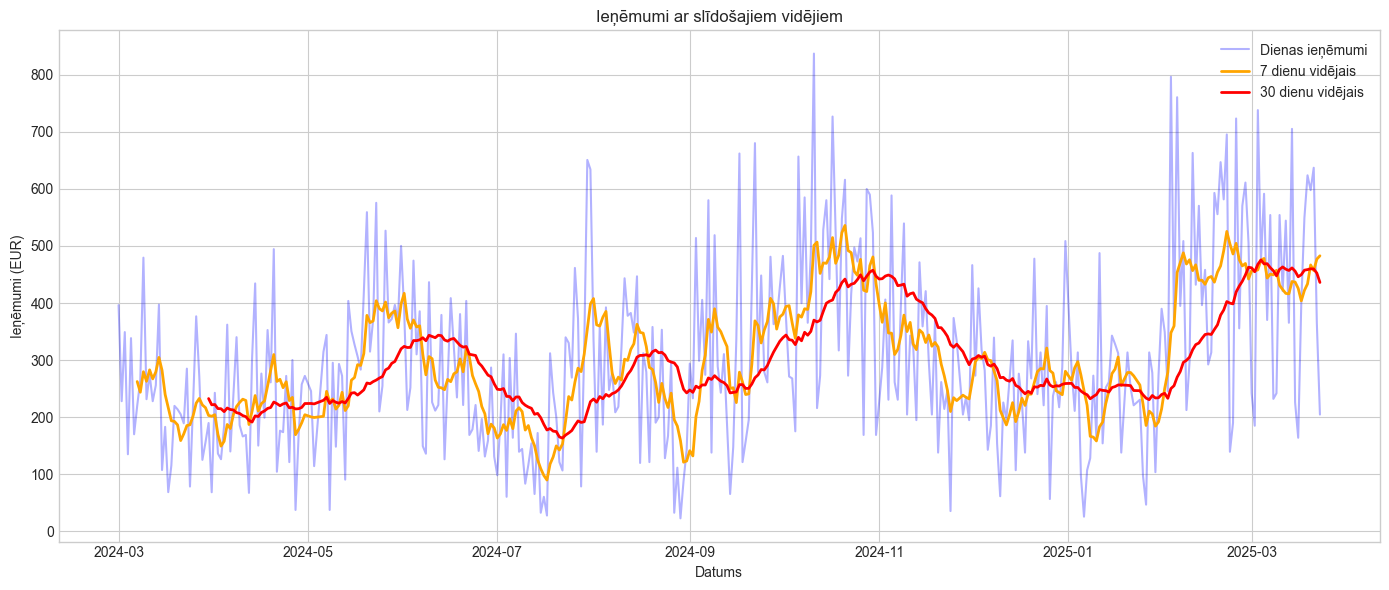

In [3]:
# Aprēķinām slīdošos vidējos
daily['MA_7'] = daily['revenue'].rolling(window=7).mean()   # 7 dienu
daily['MA_30'] = daily['revenue'].rolling(window=30).mean() # 30 dienu

# Zīmējam
plt.figure(figsize=(14, 6))
plt.plot(daily['date'], daily['revenue'], 'b-', alpha=0.3, label='Dienas ieņēmumi')
plt.plot(daily['date'], daily['MA_7'], 'orange', linewidth=2, label='7 dienu vidējais')
plt.plot(daily['date'], daily['MA_30'], 'red', linewidth=2, label='30 dienu vidējais')
plt.title('Ieņēmumi ar slīdošajiem vidējiem')
plt.xlabel('Datums')
plt.ylabel('Ieņēmumi (EUR)')
plt.legend()
plt.tight_layout()
plt.show()

---

## 3.2 Polinomu regresija

Lineārā regresija meklē taisnu līniju. Bet ja dati nav lineāri?

**Polinomu regresija** var atrast līknes!

- 2. pakāpes polinoms: `y = ax² + bx + c`
- 3. pakāpes polinoms: `y = ax³ + bx² + cx + d`

📖 [PolynomialFeatures dokumentācija](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

In [4]:
# Sagatavojam datus
X = daily['day_number'].values.reshape(-1, 1)
y = daily['revenue'].values

# Lineārā regresija
lin_model = LinearRegression()
lin_model.fit(X, y)
lin_pred = lin_model.predict(X)

# 2. pakāpes polinomu regresija
poly2 = PolynomialFeatures(degree=2)
X_poly2 = poly2.fit_transform(X)
poly2_model = LinearRegression()
poly2_model.fit(X_poly2, y)
poly2_pred = poly2_model.predict(X_poly2)

# 3. pakāpes polinomu regresija
poly3 = PolynomialFeatures(degree=3)
X_poly3 = poly3.fit_transform(X)
poly3_model = LinearRegression()
poly3_model.fit(X_poly3, y)
poly3_pred = poly3_model.predict(X_poly3)

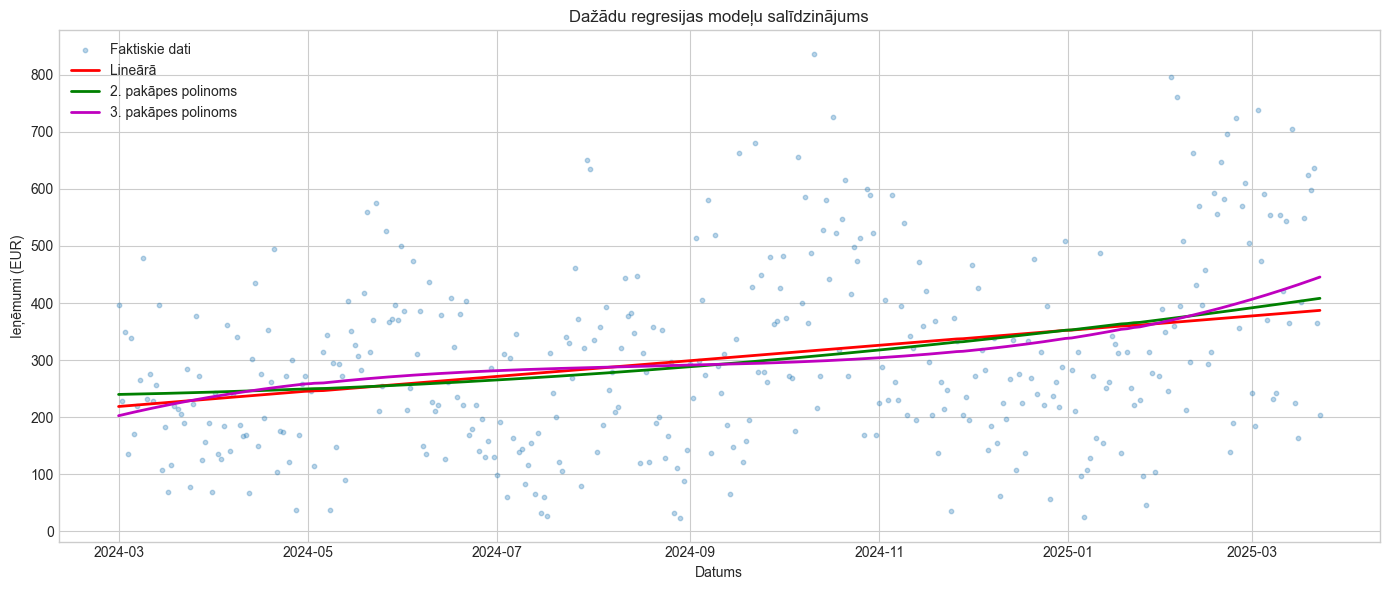

In [5]:
# Salīdzinām visus modeļus
plt.figure(figsize=(14, 6))
plt.scatter(daily['date'], y, alpha=0.3, s=10, label='Faktiskie dati')
plt.plot(daily['date'], lin_pred, 'r-', linewidth=2, label='Lineārā')
plt.plot(daily['date'], poly2_pred, 'g-', linewidth=2, label='2. pakāpes polinoms')
plt.plot(daily['date'], poly3_pred, 'm-', linewidth=2, label='3. pakāpes polinoms')
plt.title('Dažādu regresijas modeļu salīdzinājums')
plt.xlabel('Datums')
plt.ylabel('Ieņēmumi (EUR)')
plt.legend()
plt.tight_layout()
plt.show()

---

## 3.3 Modeļu kvalitātes novērtēšana

Kā zināt, kurš modelis ir labāks?

**R² (R-squared)** - cik labi modelis izskaidro datu variāciju
- 1.0 = ideāls
- 0.0 = tikpat labs kā vienkārši vidējais
- Var būt negatīvs (ļoti slikts)

**MAE (Mean Absolute Error)** - vidējā kļūda EUR

In [6]:
# Aprēķinām kvalitātes rādītājus
models = {
    'Lineārā': lin_pred,
    '2. pakāpes polinoms': poly2_pred,
    '3. pakāpes polinoms': poly3_pred
}

print("Modeļu kvalitātes salīdzinājums:")
print("-" * 50)
print(f"{'Modelis':<25} {'R²':>10} {'MAE (EUR)':>12}")
print("-" * 50)

for name, pred in models.items():
    r2 = r2_score(y, pred)
    mae = mean_absolute_error(y, pred)
    print(f"{name:<25} {r2:>10.4f} {mae:>12.2f}")

Modeļu kvalitātes salīdzinājums:
--------------------------------------------------
Modelis                           R²    MAE (EUR)
--------------------------------------------------
Lineārā                       0.0931       122.38
2. pakāpes polinoms           0.0966       122.21
3. pakāpes polinoms           0.1047       120.99


---

## ✏️ UZDEVUMS 9: Kafijas veidu tendenču analīze

Izveido grafiku, kas parāda katra kafijas veida pārdošanas tendenci laika gaitā.

**Padomi:**
- Grupē pēc datuma un kafijas veida
- Izmanto `pivot_table` vai vairākus filtrus
- Uzzīmē katru kafijas veidu kā atsevišķu līniju

In [7]:
# TAVS KODS ŠEIT:




<details>
<summary> Klikšķini šeit, lai redzētu risinājumu</summary>

```python
# Izveidojam pivot tabulu
coffee_trends = df.groupby(['date', 'coffee_name']).size().unstack(fill_value=0)

# Aprēķinām 14 dienu slīdošo vidējo katram kafijas veidam
coffee_ma = coffee_trends.rolling(window=14).mean()

# Zīmējam
plt.figure(figsize=(14, 8))
for column in coffee_ma.columns:
    plt.plot(coffee_ma.index, coffee_ma[column], linewidth=2, label=column)

plt.title('Kafijas veidu pārdošanas tendences (14 dienu vidējais)')
plt.xlabel('Datums')
plt.ylabel('Pārdoto skaits')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
```
</details>

---

## ✏️ UZDEVUMS 10: Sezonalitātes analīze

Izveido heatmap (karstuma karti), kas parāda vidējos ieņēmumus katrai nedēļas dienai katrā mēnesī.

**Padomi:**
- Pievieno kolonnas: `df['month'] = df['date'].dt.month` un `df['weekday'] = df['date'].dt.dayofweek`
- Izmanto `pivot_table` ar `aggfunc='mean'`
- Izmanto `plt.imshow()` vai `seaborn.heatmap()`

In [8]:
# TAVS KODS ŠEIT:




<details>
<summary> Klikšķini šeit, lai redzētu risinājumu</summary>

```python
# Pievienojam kolonnas
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.dayofweek

# Izveidojam pivot tabulu
heatmap_data = df.pivot_table(
    values='money', 
    index='weekday', 
    columns='month', 
    aggfunc='mean'
)

# Nedēļas dienu un mēnešu nosaukumi
weekdays = ['Pirmd', 'Otrd', 'Trešd', 'Ceturtd', 'Piektd', 'Sestd', 'Svētd']
months = ['Mar', 'Apr', 'Mai', 'Jūn', 'Jūl', 'Aug', 'Sep', 'Okt', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']

# Zīmējam heatmap
plt.figure(figsize=(12, 6))
plt.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Vidējais pirkuma apjoms (EUR)')
plt.yticks(range(7), weekdays)
plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns)
plt.xlabel('Mēnesis')
plt.ylabel('Nedēļas diena')
plt.title('Vidējais pirkuma apjoms pa nedēļas dienām un mēnešiem')
plt.tight_layout()
plt.show()
```
</details>

---

## ✏️ UZDEVUMS 11: Pielāgota prognoze

Izveido funkciju `forecast(days)`, kas:
1. Apmāca labāko modeli (pēc R²)
2. Prognozē ieņēmumus nākamajām `days` dienām
3. Atgriež DataFrame ar datumiem un prognozēm
4. Vizualizē rezultātu

In [9]:
# TAVS KODS ŠEIT:

def forecast(days):
    """
    Prognozē ieņēmumus nākamajām 'days' dienām.
    """
    # Tava implementācija šeit
    pass


# Pārbaude
# forecast(30)

<details>
<summary> Klikšķini šeit, lai redzētu risinājumu</summary>

```python
def forecast(days):
    """
    Prognozē ieņēmumus nākamajām 'days' dienām.
    """
    # Sagatavojam datus
    X = daily['day_number'].values.reshape(-1, 1)
    y = daily['revenue'].values
    
    # Apmācām 2. pakāpes polinomu modeli
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    
    # Izveidojam nākotnes dienas
    last_day = daily['day_number'].max()
    future_days = np.arange(last_day + 1, last_day + days + 1).reshape(-1, 1)
    future_days_poly = poly.transform(future_days)
    
    # Prognozējam
    predictions = model.predict(future_days_poly)
    
    # Izveidojam datumus
    last_date = daily['date'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days)
    
    # Izveidojam rezultātu DataFrame
    result = pd.DataFrame({
        'date': future_dates,
        'predicted_revenue': predictions
    })
    
    # Vizualizējam
    plt.figure(figsize=(14, 6))
    
    # Vēsturiskie dati
    plt.plot(daily['date'], y, 'b-', alpha=0.3, label='Vēsturiskie dati')
    plt.plot(daily['date'], model.predict(X_poly), 'r-', linewidth=2, label='Modelis')
    
    # Prognoze
    plt.plot(result['date'], result['predicted_revenue'], 'g--', linewidth=2, label=f'Prognoze ({days} dienas)')
    plt.fill_between(result['date'], result['predicted_revenue'] * 0.9, result['predicted_revenue'] * 1.1, 
                     alpha=0.2, color='green', label='±10% intervāls')
    
    plt.axvline(x=last_date, color='gray', linestyle=':', linewidth=2)
    plt.title(f'Ieņēmumu prognoze nākamajām {days} dienām')
    plt.xlabel('Datums')
    plt.ylabel('Ieņēmumi (EUR)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return result

# Pārbaude
result = forecast(30)
print("\nPrognozētie ieņēmumi:")
print(result)
```
</details>

---

## ✏️ BONUSA UZDEVUMS: Tava vizualizācija!

Izveido savu unikālu vizualizāciju, izmantojot šos datus!

Idejas:
- Klientu lojalitātes analīze (cik bieži atgriežas)
- Cenu izmaiņu analīze laika gaitā
- Kafijas veidu popularitātes maiņa pa mēnešiem
- Darba dienu vs nedēļas nogales salīdzinājums

In [10]:
# TAVA UNIKĀLĀ VIZUALIZĀCIJA ŠEIT:




---

# 🏆 Apsveicam!

Tu esi pabeidzis visas nodarbības daļas!

**Ko tu iemācījies:**
- Datu ielāde un izpēte ar Pandas
- Pamata vizualizācijas (bar, line, pie)
- Tendenču līnijas ar lineāro regresiju
- Slīdošie vidējie un polinomu regresija
- Modeļu kvalitātes novērtēšana
- Datu prognozēšana

### 🔗 Turpmākai izpētei
- [Kaggle - bezmaksas datu zinātnes kursi](https://www.kaggle.com/learn)
- [Real Python - Python pamācības](https://realpython.com/)
- [Data.gov.lv - Latvijas atvērtie dati](https://data.gov.lv/)
- [Seaborn - skaistāki grafiki](https://seaborn.pydata.org/)
- [Plotly - interaktīvi grafiki](https://plotly.com/python/)

**Saglabā savu labāko vizualizāciju un dalies ar citiem!**

```python
# Lai saglabātu grafiku:
plt.savefig('mana_vizualizacija.png', dpi=150, bbox_inches='tight')
```